
## Recursive Common Table Expressions
https://www.sqlite.org/lang_with.html


```
CREATE TABLE t_zipart(
  zi TEXT primary key,
  u_id TEXT,
  zi_left_up TEXT REFERENCES  t_zipart,
  zi_left TEXT REFERENCES  t_zipart,
  zi_left_down TEXT REFERENCES  t_zipart,
  zi_up TEXT REFERENCES  t_zipart,
  zi_mid TEXT REFERENCES  t_zipart,
  zi_down TEXT REFERENCES  t_zipart,
  zi_right_up TEXT REFERENCES  t_zipart,
  zi_right TEXT REFERENCES  t_zipart,
  zi_right_down TEXT REFERENCES  t_zipart,
  zi_mid_out TEXT REFERENCES  t_zipart,
  zi_mid_in TEXT REFERENCES  t_zipart,
  ts TEXT,
  desc_cn TEXT,
  is_active TEXT,
  id_shuowen TEXT,
  hsk_note TEXT,
  desc_en TEXT
);
```

see zi_part.sql

In [1]:
!dir *.sqlite

 Volume in drive C is Windows
 Volume Serial Number is 6EA7-3DCA

 Directory of C:\Users\p2p2l\projects\wgong\zistory\zizi\dev\notebook

02/06/2024  11:53 PM         9,445,376 zizi-20240206.sqlite
               1 File(s)      9,445,376 bytes
               0 Dir(s)  180,413,538,304 bytes free


In [2]:
from utils_copy import *

from IPython.display import Image

In [6]:
sql_stmt = "select * from t_zi_part where zi='藻'"

with DBConn() as _conn:
    # db_run_sql(sql_stmt, conn=_conn)
    df = pd.read_sql(sql_stmt, _conn)

df 

,zi,u_id,zi_left_up,zi_left,zi_left_down,zi_up,zi_mid,zi_down,zi_right_up,zi_right,zi_right_down,zi_mid_out,zi_mid_in,ts,desc_cn,is_active,id_shuowen,hsk_note,desc_en
0,藻,12597,None,None,None,艹,澡,None,None,None,None,None,None,2024-01-28 13:50:40,None,Y,None,from HSK,aquatic grasses/elegant


In [7]:
sql_stmt = "select * from zi_part where zi='藻'"

with DBConn() as _conn:
    # db_run_sql(sql_stmt, conn=_conn)
    df = pd.read_sql(sql_stmt, _conn)

df 

,zi,part
0,藻,澡
1,藻,艹


### Examples - recursive

In [6]:
sql_stmt = """
WITH RECURSIVE cnt(x) AS (
    VALUES(1)         -- init
    UNION ALL 
    SELECT x+1 FROM cnt 
    WHERE x<100
)
SELECT x FROM cnt;
"""

with DBConn() as _conn:
    df_ = pd.read_sql(sql_stmt, _conn).fillna("")
    
df_

,x
0,1
1,2
2,3
3,4
4,5
...,...
95,96
96,97
97,98
98,99


### Org Chart 

Consider a table that describes the members of an organization as well as the chain-of-command within that organization:

```
CREATE TABLE org(
  name TEXT PRIMARY KEY,
  boss TEXT REFERENCES org,
  dept text,
  salary int
  -- other content omitted
);
```

Every member in the organization has a name, and most members have a single boss. (The head of the whole organization has a NULL "boss" field.) The rows of the "org" table form a tree.

In [7]:
sql_stmt = """
CREATE TABLE org(
  name TEXT PRIMARY KEY,
  boss TEXT REFERENCES org,
  role text,
  salary real
  -- other content omitted
);

insert into org 
values 
('Bob',NULL, 'CEO', 1000.0),
('Charlie','Bob', 'President', 900.0),
('Alice','Bob', 'CFO', 900.0),
('Debby','Alice', 'HR Head', 800.0),
('John','Debby', 'HR Hiring', 800.0),
('Anna','Debby', 'HR Payroll', 800.0),
('Dan','Charlie', 'Product', 850.0),
('Fred','Charlie', 'Marketing', 650.0),
('Alex','Charlie', 'Sales', 750.0),
('Albert','Dan', 'R&D', 650.0),
('Ed','Dan', 'R&D', 600.0)
;
"""

with DBConn() as _conn:
    db_run_sql(sql_stmt, conn=_conn)

[DEBUG] 
CREATE TABLE org(
  name TEXT PRIMARY KEY,
  boss TEXT REFERENCES org,
  role text,
  salary real
  -- other content omitted
);

insert into org 
values 
('Bob',NULL, 'CEO', 1000.0),
('Charlie','Bob', 'President', 900.0),
('Alice','Bob', 'CFO', 900.0),
('Debby','Alice', 'HR Head', 800.0),
('John','Debby', 'HR Hiring', 800.0),
('Anna','Debby', 'HR Payroll', 800.0),
('Dan','Charlie', 'Product', 850.0),
('Fred','Charlie', 'Marketing', 650.0),
('Alex','Charlie', 'Sales', 750.0),
('Albert','Dan', 'R&D', 650.0),
('Ed','Dan', 'R&D', 600.0)
;



In [8]:
sql_stmt = """
SELECT * from org;
"""

with DBConn() as _conn:
    df_ = pd.read_sql(sql_stmt, _conn).fillna("")
    
df_

,name,boss,role,salary
0,Bob,,CEO,1000.0
1,Charlie,Bob,President,900.0
2,Alice,Bob,CFO,900.0
3,Debby,Alice,HR Head,800.0
4,John,Debby,HR Hiring,800.0
5,Anna,Debby,HR Payroll,800.0
6,Dan,Charlie,Product,850.0
7,Fred,Charlie,Marketing,650.0
8,Alex,Charlie,Sales,750.0
9,Albert,Dan,R&D,650.0


In [12]:
dept_head = "'Alice'"
sql_stmt = f"""
WITH RECURSIVE org_chart(n) AS (
    select name from org 
        where name in ({dept_head}) or boss in ({dept_head})  -- is NULL
    UNION
    SELECT org.name 
    FROM org 
    join org_chart
         on org.boss=org_chart.n
  )
--SELECT avg(salary) FROM org WHERE org.name IN org_chart;
SELECT * FROM org_chart;
"""

with DBConn() as _conn:
    df_ = pd.read_sql(sql_stmt, _conn).fillna("")
    
print(f"dept_head = {dept_head}")
df_

dept_head = 'Alice'


,n
0,Alice
1,Debby
2,Anna
3,John


#### Controlling Depth-First Versus Breadth-First Search Of a Tree Using ORDER BY

In [24]:
dot_per_level = 3 
max_dots = 10 
fmt_dots = dot_per_level*max_dots*"."
root_node = "Bob"

sql_stmt = f"""
WITH RECURSIVE
  org_chart(name,level) AS (
    VALUES('{root_node}',0)
    UNION ALL
    SELECT org.name, org_chart.level+1
      FROM org JOIN org_chart ON org.boss=org_chart.name
     ORDER BY 2
  )
SELECT substr('{fmt_dots}',1,level*{dot_per_level}) || name as tree, level
FROM org_chart;
"""

with DBConn() as _conn:
    df_ = pd.read_sql(sql_stmt, _conn).fillna("")
    
print(f"root = {root_node}")
print(f"sql: {sql_stmt}")

root = Bob
sql: 
WITH RECURSIVE
  org_chart(name,level) AS (
    VALUES('Bob',0)
    UNION ALL
    SELECT org.name, org_chart.level+1
      FROM org JOIN org_chart ON org.boss=org_chart.name
     ORDER BY 2
  )
SELECT substr('..............................',1,level*3) || name as tree, level
FROM org_chart;



Execute SQL in SQLite console

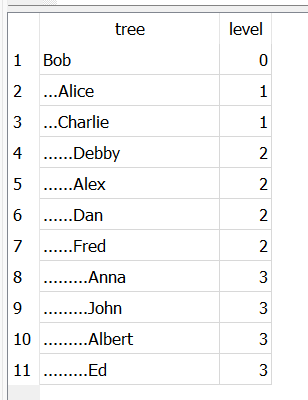

In [25]:
Image(filename='tree_breadth-first.png') 

In [26]:
dot_per_level = 3 
max_dots = 10 
fmt_dots = dot_per_level*max_dots*"."
root_node = "Bob"

sql_stmt = f"""
WITH RECURSIVE
  org_chart(name,level) AS (
    VALUES('{root_node}',0)
    UNION ALL
    SELECT org.name, org_chart.level+1
      FROM org JOIN org_chart ON org.boss=org_chart.name
     ORDER BY 2 DESC
  )
SELECT substr('{fmt_dots}',1,level*{dot_per_level}) || name as tree, level
FROM org_chart;
"""

with DBConn() as _conn:
    df_ = pd.read_sql(sql_stmt, _conn).fillna("")
    
print(f"root = {root_node}")
print(f"sql: {sql_stmt}")

root = Bob
sql: 
WITH RECURSIVE
  org_chart(name,level) AS (
    VALUES('Bob',0)
    UNION ALL
    SELECT org.name, org_chart.level+1
      FROM org JOIN org_chart ON org.boss=org_chart.name
     ORDER BY 2 DESC
  )
SELECT substr('..............................',1,level*3) || name as tree, level
FROM org_chart;



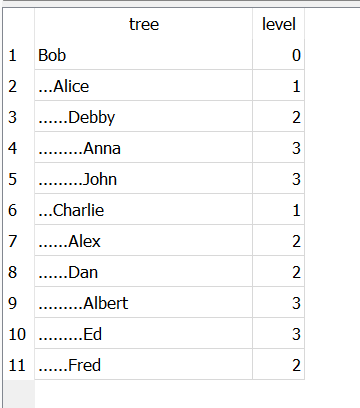

In [27]:
Image(filename='tree_depth-first.png') 

### Family Tree

In [38]:
sql_stmt = """
CREATE TABLE if not exists  family  (
  name TEXT PRIMARY KEY,
  mom TEXT REFERENCES family,
  dad TEXT REFERENCES family,
  birth_date TEXT,
  death_date TEXT -- NULL if still alive
  -- other content
);

INSERT INTO family (name, mom, dad, birth_date, death_date)
VALUES
  ('John Doe', NULL, NULL, '1970-01-01', NULL),
  ('Jane Doe', NULL, NULL, '1975-03-15', NULL),
  ('Alice Smith', 'Jane Doe', 'John Doe', '2000-02-29', NULL),
  ('Bob Smith', NULL, 'Mary Johnson', '1998-12-24', NULL),
  ('Mary Johnson', NULL, NULL, '1972-09-10', NULL),
  ('Charles Smith', 'Alice Smith', 'Bob Smith', '2003-05-18', NULL),
  ('Emily Garcia', 'Alice Smith', 'Carlos Garcia', '2005-11-07', NULL),
  ('Carlos Garcia', 'Allan Garcia', 'Gloria Goodman', '1979-04-02', NULL);

;
"""

with DBConn() as _conn:
    db_run_sql(sql_stmt, conn=_conn)

[DEBUG] 
CREATE TABLE if not exists  family  (
  name TEXT PRIMARY KEY,
  mom TEXT REFERENCES family,
  dad TEXT REFERENCES family,
  birth_date TEXT,
  death_date TEXT -- NULL if still alive
  -- other content
);

INSERT INTO family (name, mom, dad, birth_date, death_date)
VALUES
  ('John Doe', NULL, NULL, '1970-01-01', NULL),
  ('Jane Doe', NULL, NULL, '1975-03-15', NULL),
  ('Alice Smith', 'Jane Doe', 'John Doe', '2000-02-29', NULL),
  ('Bob Smith', NULL, 'Mary Johnson', '1998-12-24', NULL),
  ('Mary Johnson', NULL, NULL, '1972-09-10', NULL),
  ('Charles Smith', 'Alice Smith', 'Bob Smith', '2003-05-18', NULL),
  ('Emily Garcia', 'Alice Smith', 'Carlos Garcia', '2005-11-07', NULL),
  ('Carlos Garcia', 'Allan Garcia', 'Gloria Goodman', '1979-04-02', NULL);

;



In [46]:
child = "Emily Garcia"
sql_stmt = f"""
WITH RECURSIVE
  parent_of(name, parent) AS
    (SELECT name, mom FROM family UNION SELECT name, dad FROM family),
  ancestor_of(name) AS
    (SELECT parent FROM parent_of WHERE name='{child}'
     UNION ALL
     SELECT parent FROM parent_of JOIN ancestor_of USING(name))

select family.name, family.mom, family.dad, family.birth_date
FROM family
  where name = '{child}'
union all
SELECT 
    family.name, family.mom, family.dad, family.birth_date
FROM ancestor_of, family
 WHERE ancestor_of.name=family.name
   AND death_date IS NULL
 ORDER BY birth_date

;
"""

with DBConn() as _conn:
    df = pd.read_sql(sql_stmt, _conn)

In [47]:
df 

,name,mom,dad,birth_date
0,John Doe,None,None,1970-01-01
1,Jane Doe,None,None,1975-03-15
2,Carlos Garcia,Allan Garcia,Gloria Goodman,1979-04-02
3,Alice Smith,Jane Doe,John Doe,2000-02-29
4,Emily Garcia,Alice Smith,Carlos Garcia,2005-11-07


### ASCII-art

```
WITH RECURSIVE
  xaxis(x) AS (VALUES(-2.0) UNION ALL SELECT x+0.05 FROM xaxis WHERE x<1.2),
  yaxis(y) AS (VALUES(-1.0) UNION ALL SELECT y+0.1 FROM yaxis WHERE y<1.0),
  m(iter, cx, cy, x, y) AS (
    SELECT 0, x, y, 0.0, 0.0 FROM xaxis, yaxis
    UNION ALL
    SELECT iter+1, cx, cy, x*x-y*y + cx, 2.0*x*y + cy FROM m 
     WHERE (x*x + y*y) < 4.0 AND iter<28
  ),
  m2(iter, cx, cy) AS (
    SELECT max(iter), cx, cy FROM m GROUP BY cx, cy
  ),
  a(t) AS (
    SELECT group_concat( substr(' .+*#', 1+min(iter/7,4), 1), '') 
    FROM m2 GROUP BY cy
  )
SELECT group_concat(rtrim(t),x'0a') FROM a;
```

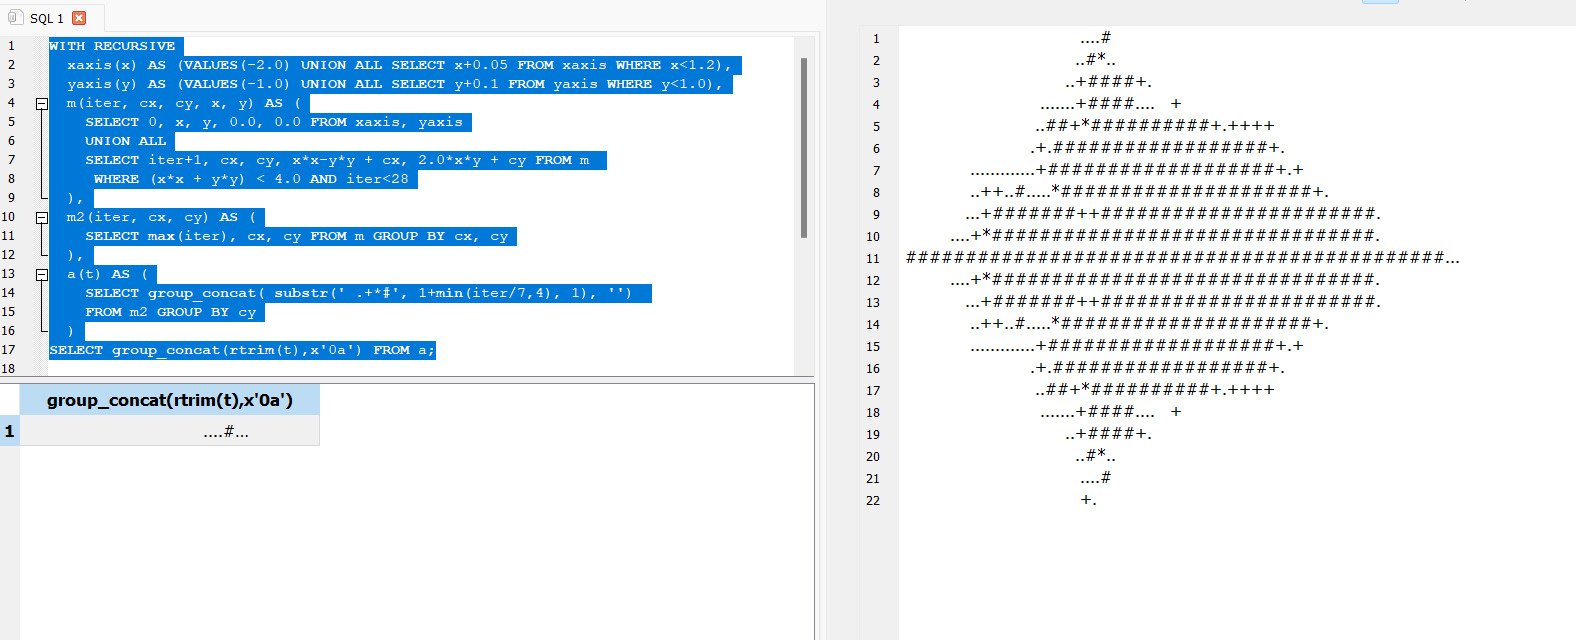

In [48]:
Image(filename='ascii-art.png') 

### Zi-tree

In [60]:
sql_stmt = f"""
select * from t_zi_part where zi='藻';
"""

with DBConn() as _conn:
    df = pd.read_sql(sql_stmt, _conn)

In [61]:
df 

,zi,u_id,zi_left_up,zi_left,zi_left_down,zi_up,zi_mid,zi_down,zi_right_up,zi_right,zi_right_down,zi_mid_out,zi_mid_in,ts,desc_cn,is_active,id_shuowen,hsk_note,desc_en
0,藻,12597,None,None,None,艹,澡,None,None,None,None,None,None,2024-01-28 13:50:40,None,Y,None,from HSK,aquatic grasses/elegant


In [62]:
zi_columns = df.columns 

In [63]:
sqls = []
root = "藻"
for c in [c for c in zi_columns if c.startswith("zi_")]:
    sql = f"select zi, {c} as part from t_zi_part where zi='{root}' and  {c} is not null"
    sqls.append(sql)

In [64]:
sql_stmt = "\n union all \n".join(sqls)
print(sql_stmt)

select zi, zi_left_up as part from t_zi_part where zi='藻' and  zi_left_up is not null
 union all 
select zi, zi_left as part from t_zi_part where zi='藻' and  zi_left is not null
 union all 
select zi, zi_left_down as part from t_zi_part where zi='藻' and  zi_left_down is not null
 union all 
select zi, zi_up as part from t_zi_part where zi='藻' and  zi_up is not null
 union all 
select zi, zi_mid as part from t_zi_part where zi='藻' and  zi_mid is not null
 union all 
select zi, zi_down as part from t_zi_part where zi='藻' and  zi_down is not null
 union all 
select zi, zi_right_up as part from t_zi_part where zi='藻' and  zi_right_up is not null
 union all 
select zi, zi_right as part from t_zi_part where zi='藻' and  zi_right is not null
 union all 
select zi, zi_right_down as part from t_zi_part where zi='藻' and  zi_right_down is not null
 union all 
select zi, zi_mid_out as part from t_zi_part where zi='藻' and  zi_mid_out is not null
 union all 
select zi, zi_mid_in as part from t_zi_par

In [65]:
sqls = []
for c in [c for c in zi_columns if c.startswith("zi_")]:
    sql = f"select  tzp.zi, tzp.{c} as part from t_zi_part tzp join zi_part zp on zp.part = tzp.zi where tzp.{c} is not null"
    sqls.append(sql)
sql_stmt = "\n union all \n".join(sqls)
print(sql_stmt)

select  tzp.zi, tzp.zi_left_up as part from t_zi_part tzp join zi_part zp on zp.part = tzp.zi where tzp.zi_left_up is not null
 union all 
select  tzp.zi, tzp.zi_left as part from t_zi_part tzp join zi_part zp on zp.part = tzp.zi where tzp.zi_left is not null
 union all 
select  tzp.zi, tzp.zi_left_down as part from t_zi_part tzp join zi_part zp on zp.part = tzp.zi where tzp.zi_left_down is not null
 union all 
select  tzp.zi, tzp.zi_up as part from t_zi_part tzp join zi_part zp on zp.part = tzp.zi where tzp.zi_up is not null
 union all 
select  tzp.zi, tzp.zi_mid as part from t_zi_part tzp join zi_part zp on zp.part = tzp.zi where tzp.zi_mid is not null
 union all 
select  tzp.zi, tzp.zi_down as part from t_zi_part tzp join zi_part zp on zp.part = tzp.zi where tzp.zi_down is not null
 union all 
select  tzp.zi, tzp.zi_right_up as part from t_zi_part tzp join zi_part zp on zp.part = tzp.zi where tzp.zi_right_up is not null
 union all 
select  tzp.zi, tzp.zi_right as part from t_zi_part

In [57]:
with DBConn() as _conn:
    df = pd.read_sql(sql_stmt, _conn)

In [58]:
df 

,zi,part
0,藻,艹
1,藻,澡


In [10]:
root = "澡" # "藻"

In [11]:
sql_stmt = f"""
WITH 
  parts(zi, part) AS (
  select zi, zi_left_up as part from t_zi_part where zi_left_up is not null
     union all 
    select zi, zi_left as part from t_zi_part where  zi_left is not null
     union all 
    select zi, zi_left_down as part from t_zi_part where  zi_left_down is not null
     union all 
    select zi, zi_up as part from t_zi_part where  zi_up is not null
     union all 
    select zi, zi_mid as part from t_zi_part where   zi_mid is not null
     union all 
    select zi, zi_down as part from t_zi_part where  zi_down is not null
     union all 
    select zi, zi_right_up as part from t_zi_part where  zi_right_up is not null
     union all 
    select zi, zi_right as part from t_zi_part where  zi_right is not null
     union all 
    select zi, zi_right_down as part from t_zi_part where  zi_right_down is not null
     union all 
    select zi, zi_mid_out as part from t_zi_part where  zi_mid_out is not null
     union all 
    select zi, zi_mid_in as part from t_zi_part where  zi_mid_in is not null
)
SELECT zi, part 
    FROM parts WHERE zi='{root}'
;
"""
with DBConn() as _conn:
    df = pd.read_sql(sql_stmt, _conn)

In [12]:
df 

,zi,part
0,澡,氵
1,澡,喿


In [8]:
root =  "藻"
sql_stmt = f"""
WITH RECURSIVE
  child_of(zi, part) AS (
    SELECT zi, part 
    FROM zi_part WHERE zi='{root}'
UNION ALL
     SELECT zp.zi, zp.part  
     FROM  zi_part zp join child_of c
         on zp.zi = c.part
)
SELECT * FROM child_of
;
"""
with DBConn() as _conn:
    df = pd.read_sql(sql_stmt, _conn)

In [9]:
df 

,zi,part
0,藻,澡
1,藻,艹
2,澡,喿
3,澡,氵
4,喿,品
5,喿,木
6,品,口
7,品,口
8,品,口


In [ ]:
df 